ใน ep นี้

# 0. Install

เราจะต้อง Install kaggle เพื่อ Download Dataset

In [1]:
# ## Colab
# ! curl -s https://course.fast.ai/setup/colab | bash
# ! pip install kaggle --upgrade

In [2]:
# ## Check GPU
# ! nvidia-smi

# 1. Import Library

Import Libray ที่เราต้องการใช้

In [3]:
import math
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import cm
from matplotlib import pyplot as plt
import seaborn as sns

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

from ranger import Ranger

In [4]:
%matplotlib inline

In [5]:
fastai.__version__

'1.0.59'

# 2. เตรียม Path สำหรับดาวน์โหลดข้อมูล

กำหนด path ของ Config File และ Dataset ว่าจะอยู่ใน Google Drive ถ้าเราใช้ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) หรือ อยู่ใน HOME ถ้าเราใช้ VM ธรรมดา และกำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

ในกรณีใช้ Colab ให้ Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

In [6]:
dataset = 'histopathologic-cancer-detection'
dataset2 = 'tywangty/histopathologiccancerwsi'

# # Google Colab
# config_path = Path('/content/drive')
# data_path_base = Path('/content/datasets/')

# data_path = data_path_base/dataset
# data_path2 = data_path_base/dataset2

# from google.colab import drive
# drive.mount(str(config_path))
# os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

# VM
config_path = Path(os.getenv("HOME"))
data_path = config_path/"datasets"/dataset
data_path2 = config_path/"datasets"/dataset2

data_path.mkdir(parents=True, exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

# 3. Dataset

ในเคสนี้ เราจะ Download ข้อมูล Dataset ที่เกี่ยวข้องทั้งหมดมาเก็บไว้ แบ่งเป็นรูปฟิล์ม X-Ray ขนาดต่าง ๆ ข้อมูลต้นฉบับ ข้อมูล Test Set, etc.

Dataset เราจะดึงจาก Kaggle วิธี Download kaggle.json ให้ดูจาก ep ที่แล้ว

เมื่อได้ kaggle.json มาแล้ว ในกรณีใช้ Google Colab ให้นำมาใส่ไว้ในโฟลเดอร์ My Drive/.kaggle ใน Google Drive ของเรา เป็น My Drive/.kaggle/kaggle.json ถ้าใช้ VM ให้ใส่ใน HOME/.kaggle/

สั่งดาวน์โหลด Dataset จาก Kaggle พร้อมทั้ง unzip ไว้ใน data_path

In [7]:
# !kaggle competitions download -c {dataset} -p "{data_path}"
# !kaggle datasets download {dataset2} -p "{data_path2}" --unzip

Unzip ไฟล์ที่ดาวน์โหลดจาก Kaggle Competition

In [8]:
data_path.ls()

[PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/sample_submission.csv'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/test.zip'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train.zip'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/test'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train_labels.csv'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/histopathologic-cancer-detection.zip'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train')]

In [9]:
## VM
# ! unzip -q {data_path}/histopathologic-cancer-detection.zip -d {data_path}

In [10]:
# ! unzip -q {data_path}/train.zip -d {data_path}/train
# ! unzip -q {data_path}/test.zip -d {data_path}/test
# ! unzip -q {data_path}/sample_submission.csv.zip -d {data_path}
# ! unzip -q {data_path}/train_labels.csv.zip -d {data_path}

# 4. Data

## 4.1 Image File and Label CSV

In [11]:
data_path.ls()

[PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/sample_submission.csv'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/test.zip'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train.zip'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/test'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train_labels.csv'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/histopathologic-cancer-detection.zip'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train')]

In [12]:
(data_path/'train').ls()[:5]

[PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train/5618278daa5eba1ccc43e57702575dd008a5afec.tif'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train/e36a50a298ce88b2b3bc07fbd7fb5d9142c9d4f3.tif'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train/b1c4ea219379be6936b3b8e3bda1f06f6c527fc3.tif'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train/215b23e7ed429b7409b86d3b5fd1b2fa3af807f5.tif'),
 PosixPath('/home/jupyter/datasets/histopathologic-cancer-detection/train/2a977f8589877152bd1f8ee09ab2c12301914967.tif')]

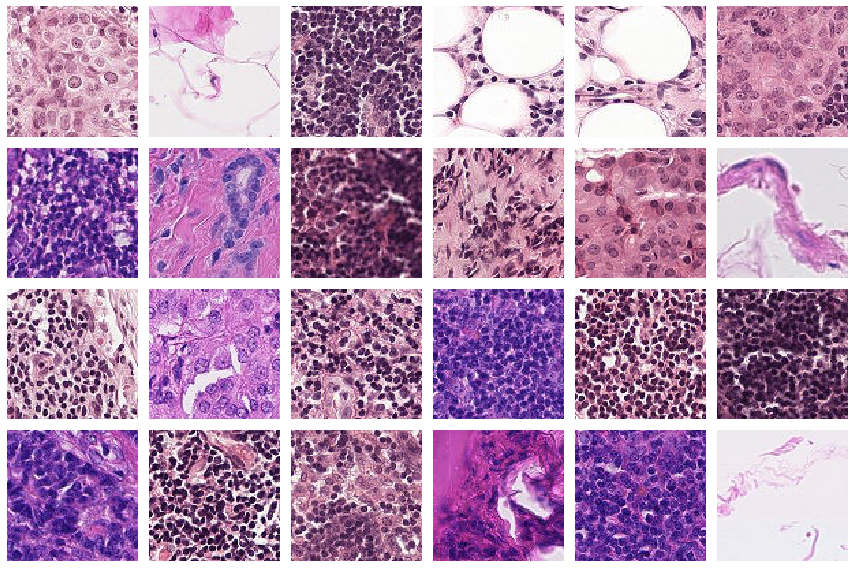

In [13]:
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
for ax, f in zip(axes.flatten(), (data_path/'train').ls()[:24]):
    ax.imshow(PIL.Image.open(f), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [14]:
df =  pd.read_csv(data_path/'train_labels.csv')
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [15]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


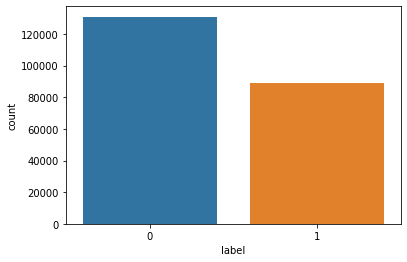

In [16]:
sns.countplot(x="label", data=df)

## 4.2 Split by WSI

WSI คืออะไร

In [17]:
def return_tumor_or_not(dic, one_id):
    return dic[one_id]

def create_dict():
    df = pd.read_csv(data_path/"train_labels.csv")
    result_dict = {}
    for index in range(df.shape[0]):
        one_id = df.iloc[index,0]
        tumor_or_not = df.iloc[index,1]
        result_dict[one_id] = int(tumor_or_not)
    return result_dict

def find_missing(train_ids, cv_ids):
    all_ids = set(pd.read_csv(data_path/"train_labels.csv")['id'].values)
    wsi_ids = set(train_ids + cv_ids)

    missing_ids = list(all_ids-wsi_ids)
    return missing_ids


def generate_split():
    ids = pd.read_csv(data_path2/"patch_id_wsi.csv")
    wsi_dict = {}
    for i in range(ids.shape[0]):
        wsi = ids.iloc[i,1]
        train_id = ids.iloc[i,0]
        wsi_array = wsi.split('_')
        number = int(wsi_array[3])
        if wsi_dict.get(number) is None:
            wsi_dict[number] = [train_id]
        else:
            wsi_dict[number].append(train_id)

    wsi_keys = list(wsi_dict.keys())
    np.random.seed()
    np.random.shuffle(wsi_keys)
    amount_of_keys = len(wsi_keys)

    keys_for_train = wsi_keys[0:int(amount_of_keys*0.8)]
    keys_for_cv = wsi_keys[int(amount_of_keys*0.8):]
    train_ids = []
    cv_ids = []

    for key in keys_for_train:
        train_ids += wsi_dict[key]

    for key in keys_for_cv:
        cv_ids += wsi_dict[key]

    dic = create_dict()

    missing_ids = find_missing(train_ids, cv_ids)
    missing_ids_total = len(missing_ids)
    np.random.seed()
    np.random.shuffle(missing_ids)

    train_missing_ids = missing_ids[0:int(missing_ids_total*0.8)]
    cv_missing_ids = missing_ids[int(missing_ids_total*0.8):]

    train_ids += train_missing_ids
    cv_ids += cv_missing_ids

    train_labels = []
    cv_labels = []

    train_tumor = 0
    for one_id in train_ids:
        temp = return_tumor_or_not(dic, one_id)
        train_tumor += temp
        train_labels.append(temp)

    cv_tumor = 0
    for one_id in cv_ids:
        temp = return_tumor_or_not(dic, one_id)
        cv_tumor += temp
        cv_labels.append(temp)
    total = len(train_ids) + len(cv_ids)

    print("Amount of train labels: {}, {}/{}".format(len(train_ids), train_tumor, len(train_ids)-train_tumor))
    print("Amount of cv labels: {}, {}/{}".format(len(cv_ids), cv_tumor, len(cv_ids) - cv_tumor))
    print("Percentage of cv labels: {}".format(len(cv_ids)/total))

    return train_ids, cv_ids, train_labels, cv_labels

In [18]:
train_ids, cv_ids, train_labels, cv_labels = generate_split()

Amount of train labels: 171611, 70886/100725
Amount of cv labels: 48414, 18231/30183
Percentage of cv labels: 0.22003863197363935


In [19]:
train_ids[:5]

['65d585c2afc24a8b90a190c9d8aca44618cbdebc',
 '7ade81bd0f3f24940e0f5bf607c99cd1ef91042e',
 '278dbe18889a9356acf149ebd4f7922cd67da7cf',
 '15c2e08ed6f07c133da810148f2db3147ea69fb7',
 '9acfde95d25b80fb36439140ef86a190493572e6']

In [20]:
all(x in train_ids for x in cv_ids), all(x in cv_ids for x in train_ids)

(False, False)

# 5. Data Pipeline

In [21]:
bs = 256
SZ = 64
path = data_path

In [22]:
# tfms = get_transforms(flip_vert=True, max_rotate=180., max_zoom=1.1, max_warp=0.)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180., max_zoom=1.35, 
                      max_warp=0., max_lighting=0.05)

In [23]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-180.0, 180.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.35), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do

ใช้ [DataBlock API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) สร้าง [DataBunch](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) เตรียมส่งให้ Model สำหรับเทรน โดย [Train/Validation Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) 90/10, Label เป็น Binary Classification 0/1 , ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) รวมถึง Flip Vertical แล้ว [Normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/) ด้วย imagenet_stats

In [24]:
train_idx = df.loc[df.id.isin(train_ids)].index
cv_idx = df.loc[df.id.isin(cv_ids)].index

In [25]:
# Create databunch
data = (ImageList.from_df(path=path/'train', df=df, suffix='.tif')#[:1000]
#         .split_by_rand_pct(0.1, seed=1234)    # Split by Random
        .split_by_idxs(train_idx, cv_idx)       # Split by idx from WSI
        .label_from_df(cols='label')
        .add_test((path/'test').ls(), label=None)
        .transform(tfms, size=SZ)
        .databunch(bs=bs)
        .normalize())

ได้ Traing Set และ Validation Set จำนวนดังนี้

In [26]:
len(data.train_ds), len(data.valid_ds)

(171611, 48414)

ดูข้อมูล 1 Batch 

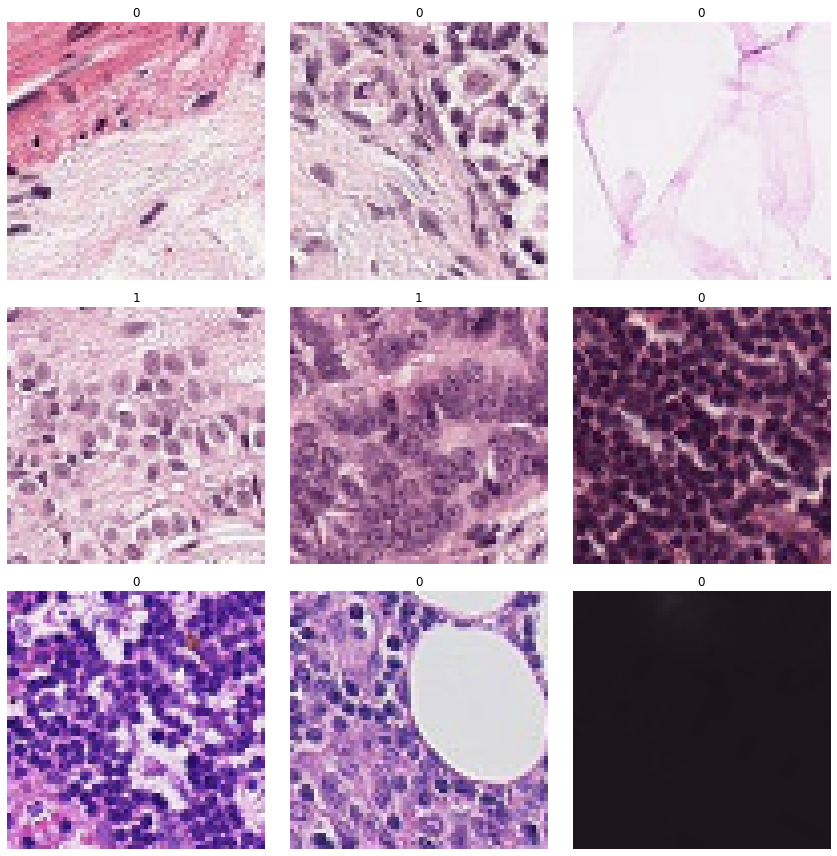

In [27]:
data.show_batch(rows=3, figsize=(12, 12))

# 6. Model

เราจะใช้ [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) ต่างจาก ep ก่อน ๆ ที่ใช้ Resnet เปลี่ยนมาเป็น densenet161 ใช้ Label Smoothing Cross Entropy Loss Function จะอธิบายต่อไป และ Ranger Optimizer จะอธิบายต่อไป

แล้วแปลงโมเดลเป็นแบบ Mixed Precision Training เพื่อประหยัด Memory และเพิ่มประสิทธิภาพ

In [28]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = Ranger

In [29]:
learn = cnn_learner(data, models.densenet161, metrics=[accuracy, AUROC()], 
                    model_dir=config_path/'My Drive/models', 
                    loss_func=loss_func, ps=0.8, opt_func=opt_func, 
                    callback_fns=[ShowGraph, PeakMemMetric]).to_fp16()

In [30]:
# learn.summary()

# 7. Train

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 7.59E-02


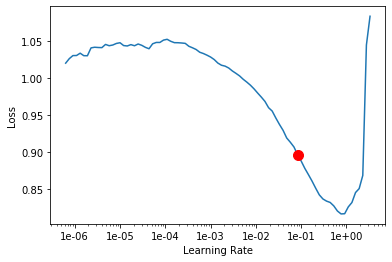

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_last=1)

## 7.1 Train Last Layer

In [31]:
lr = 1e-1

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.366285,0.364752,0.902194,0.965359,0,6,24,5492,15:30
1,0.351790,0.339590,0.916128,0.975366,0,6,0,2638,05:42
2,0.312720,0.305460,0.935796,0.981570,0,6,0,2638,05:41
3,0.298073,0.302425,0.936740,0.983111,0,6,0,2638,05:43


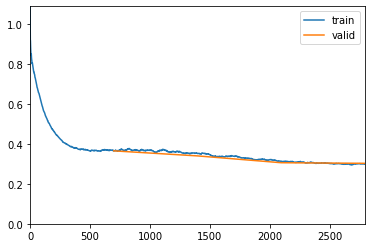

In [33]:
learn.fit_one_cycle(4, max_lr=lr, wd=(1e-4, 1e-4, 1e-1),   
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='auroc')])

In [34]:
learn.save('01g-densenet161-1')

In [35]:
# learn.load('01g-densenet161-1');

In [32]:
learn.load('bestmodel_3');

In [33]:
# learn.show_results(rows=5, figsize=(10, 12))

In [67]:
# import IPython.display as ipd
# ipd.Audio(url="http://www.w3schools.com/html/horse.ogg",
#                               autoplay=True) 

## 7.2 Unfreeze and Train Whole Model

In [35]:
learn.unfreeze()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 2.09E-04


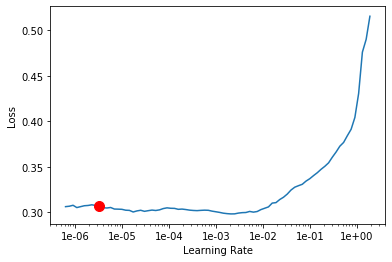

In [36]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_last=0)

In [37]:
lr = slice(3e-6, 3e-4)

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.298840,0.298281,0.939425,0.983980,0,6,378,2482,07:46
1,0.294505,0.305795,0.934974,0.982928,0,6,-18,2716,07:42
2,0.294473,0.301196,0.938433,0.983700,0,6,0,2748,07:41
3,0.292403,0.293480,0.942037,0.984539,0,6,0,2748,07:40
4,0.287305,0.294288,0.942860,0.984824,0,6,0,2748,07:39
5,0.285849,0.296447,0.942037,0.984448,0,6,0,2748,07:40


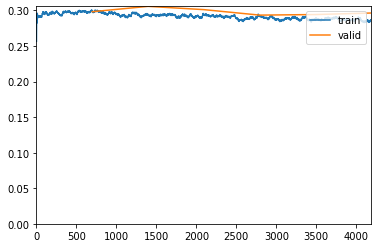

In [38]:
learn.fit_one_cycle(6, wd=(1e-4, 1e-4, 1e-1), max_lr=lr, 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='auroc')])

In [39]:
learn.save('01g-densenet161-2')

In [30]:
learn.load('01g-densenet161-2');

In [32]:
# learn.load('bestmodel_5');

In [41]:
# learn.show_results(rows=5, figsize=(10, 12))

In [68]:
# import IPython.display as ipd
# ipd.Audio(url="http://www.w3schools.com/html/horse.ogg",
#                               autoplay=True) 

## 7.3 Increase Resolution to 96

In [31]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [32]:
bs = 128
SZ = 96
path = data_path

In [33]:
# tfms = get_transforms(flip_vert=True, max_rotate=180., max_zoom=1.1, max_warp=0.)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180., max_zoom=1.35, 
                      max_warp=0., max_lighting=0.05)

In [34]:
# Create databunch
data = (ImageList.from_df(path=path/'train', df=df, suffix='.tif')#[:1000]
#         .split_by_rand_pct(0.1, seed=1234)    # Split by Random
        .split_by_idxs(train_idx, cv_idx)       # Split by idx from WSI
        .label_from_df(cols='label')
        .add_test((path/'test').ls(), label=None)
        .transform(tfms, size=SZ)
        .databunch(bs=bs)
        .normalize())

In [35]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = Ranger

In [36]:
learn = cnn_learner(data, models.densenet161, metrics=[accuracy, AUROC()], 
                    model_dir=config_path/'My Drive/models', 
                    loss_func=loss_func, ps=0.8, opt_func=opt_func, 
                    callback_fns=[ShowGraph, PeakMemMetric]).to_fp16()

In [37]:
learn.load('01g-densenet161-2');
# learn.load('bestmodel_5');
learn.freeze()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-07


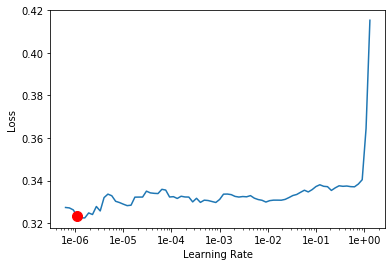

In [38]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_last=1)

In [39]:
lr = 3e-2

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.333279,0.313918,0.934812,0.979309,0,6,36,5052,12:37
1,0.323980,0.324605,0.923369,0.978819,0,6,0,3004,12:37
2,0.293659,0.265779,0.961519,0.990786,0,6,0,3004,12:35
3,0.288651,0.263523,0.963007,0.991498,0,6,0,3004,12:36


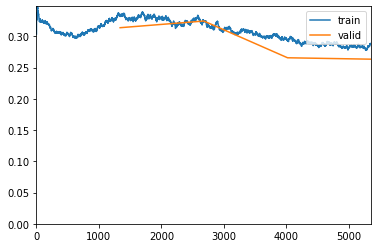

In [40]:
learn.fit_one_cycle(4, max_lr=lr, wd=(1e-4, 1e-4, 1e-1),  
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='auroc')])

In [41]:
learn.save('01g-densenet161-3')

In [42]:
# learn.load('01g-densenet161-3');

In [43]:
learn.load('bestmodel_3');

set state called


In [44]:
# learn.show_results(rows=5, figsize=(10, 12))

In [69]:
# import IPython.display as ipd
# ipd.Audio(url="http://www.w3schools.com/html/horse.ogg",
#                               autoplay=True) 

## 7.4 Unfreeze and Train Whole Model 96

In [46]:
learn.unfreeze()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


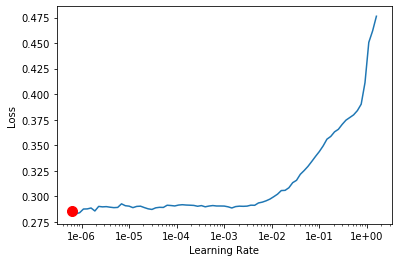

In [47]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_last=0)

In [48]:
lr = slice(1e-6, 1e-4)

epoch,train_loss,valid_loss,accuracy,auroc,cpu used,peak,gpu used,peak,time
0,0.279687,0.262694,0.963544,0.991801,0,6,398,2920,16:55
1,0.281663,0.261590,0.964205,0.992135,0,6,-2,3164,16:49
2,0.283548,0.261191,0.964205,0.992225,0,6,0,3170,16:47
3,0.277948,0.261089,0.963626,0.992180,0,6,0,3170,16:47
4,0.278386,0.259150,0.965217,0.992555,0,6,0,3170,16:48
5,0.279840,0.258439,0.966621,0.992691,0,6,0,3170,16:54
6,0.271290,0.258715,0.965857,0.992870,0,6,0,3170,17:06
7,0.274426,0.258985,0.966002,0.992584,0,6,0,3170,17:13
8,0.274993,0.259471,0.965258,0.992278,0,6,0,3170,17:14
9,0.273247,0.257926,0.966373,0.992704,0,6,0,3170,17:12


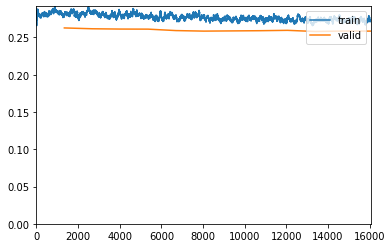

In [49]:
learn.fit_one_cycle(12, wd=(1e-4, 1e-4, 1e-1), max_lr=lr, 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='auroc')])

In [50]:
learn.save('01g-densenet161-4')

In [51]:
# learn.load('01g-densenet161-4');

In [52]:
learn.load('bestmodel_11');

set state called


In [53]:
# learn.show_results(rows=5, figsize=(10, 12))

In [70]:
# import IPython.display as ipd
# ipd.Audio(url="http://www.w3schools.com/html/horse.ogg",
#                               autoplay=True) 

# 8. Interpret

In [55]:
interpretation = ClassificationInterpretation.from_learner(learn.to_fp32())

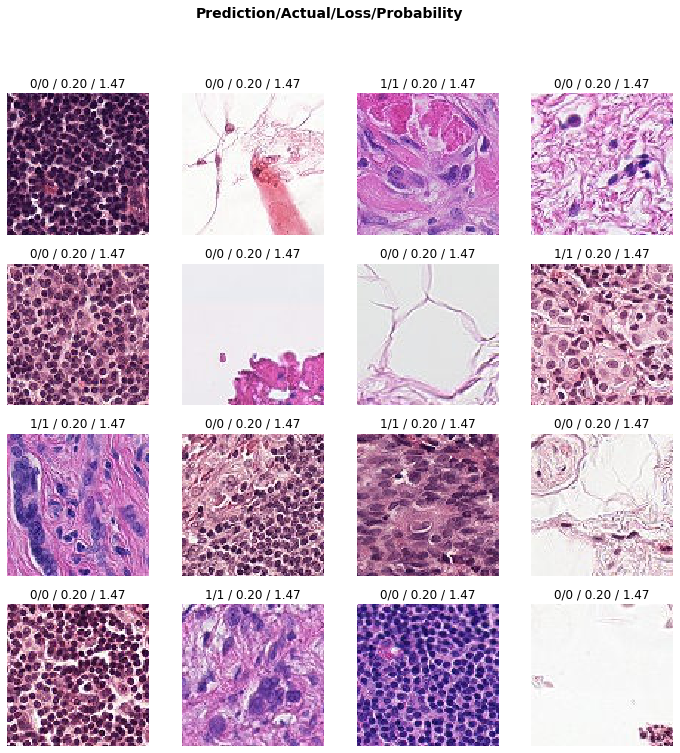

In [56]:
interpretation.plot_top_losses(16, figsize=(12,12), heatmap=True, largest=False)

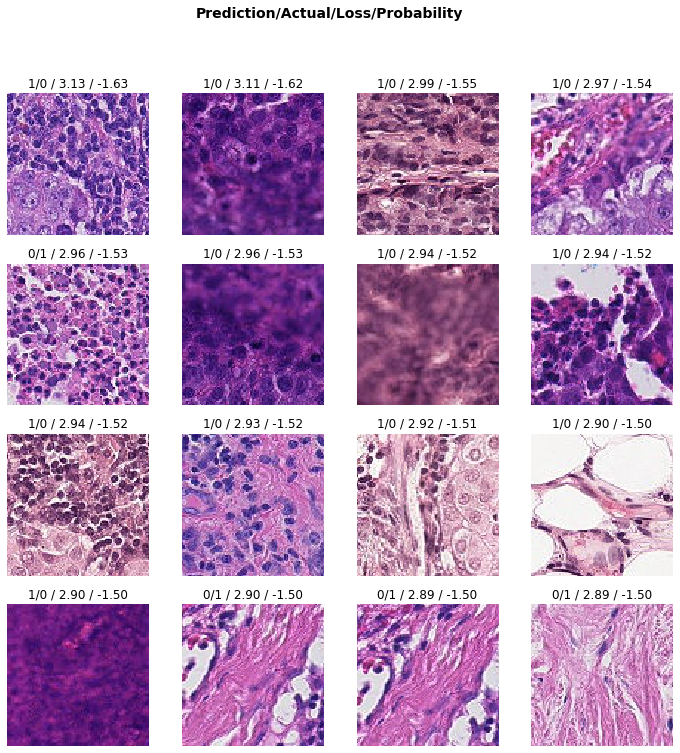

In [57]:
interpretation.plot_top_losses(16, figsize=(12,12), heatmap=True, largest=True)

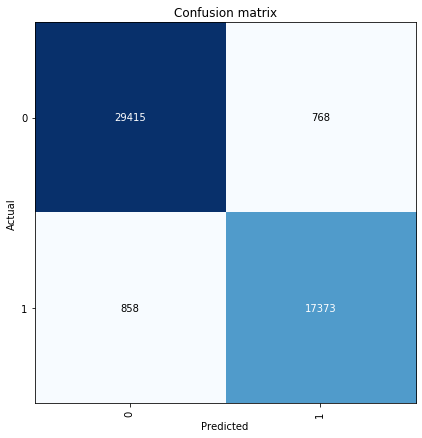

In [58]:
interpretation.plot_confusion_matrix(figsize=(6,6), dpi=72)

# 9. Submit Predictions to Kaggle

ส่งผลการวินิจฉัยข้อมูลตัวอย่าง ใน Test Set ไปให้ Kaggle ตรวจ

In [59]:
# ## Predictions for test set
# preds, _ = learn.get_preds(ds_type=DatasetType.Test)

## TTA Test Time Augmentation
preds, _ = learn.TTA(ds_type=DatasetType.Test, scale=1.2)

# preds.shape

In [60]:
preds[:10].argmax(dim=1)

tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 0])

แปลงเป็น DataFrame

In [61]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'id': ids, 'label': preds.argmax(dim=1)})
sub_df.head()

,id,label
0,b33823030c33712625ecbc8b25db5a98b00cd57a,1
1,c6bb2d36064ac1eae7ad89ccc078ae627cea1017,1
2,6ae7687b46a8028ca621aa992a5aa6c88cf36ef2,1
3,4058827105f5aa0b82f8715dd0facdf4b17d137e,0
4,9bef95381d07a2f56359a29448e9366e12797894,0


In [62]:
sub_df.shape

(57458, 2)

In [63]:
sub_df.to_csv('submission.csv', index=False)

In [64]:
! kaggle competitions submit {dataset} -f {'submission.csv'} -m "densenet161 sz=64-96 zoom1.35 rotate180 2lin_ftrs wd1e-4-4-1 ps08 labelSmoothLoss Ranger TTA scale12 51"

100%|███████████████████████████████████████| 2.36M/2.36M [00:13<00:00, 184kB/s]
Successfully submitted to Histopathologic Cancer Detection

In [66]:
# import IPython.display as ipd
# ipd.Audio(url="http://www.w3schools.com/html/horse.ogg",
#                               autoplay=True) 




| Name           | Submitted    | Wait time | Execution time | Score   |
|----------------|--------------|-----------|----------------|---------|
| submission.csv | a day ago    | 0 seconds | 1 seconds      | x  |


เราได้ Public Leaderboard x, Private Leaderboard x อยู่ที่อันดับ x จาก 1,157 team ดังตารางด้านล่าง = Top x%

| #   	| Team Name      	| Score  	| Last 	|
|-----	|----------------	|--------	|------	|
| 278 	| UWRad          	| 0.8113 	| 2mo  	|
| 279 	| Mitul          	| 0.8105 	| 2mo  	|
| 280 	| diCELLa        	| 0.8096 	| 2mo  	|
| 281 	| lucaskg        	| 0.8094 	| 2mo  	|
| 282 	| Insaf Ashrapov 	| 0.8091 	| 2mo  	|



Top 10 ใน Private Leaderboard คือ อันดับที่ 115 จาก 1157 ทีม Score = 0.9738

# สรุป

* เราได้สร้าง AI วิจิฉัย x ที่ทำงานได้อย่าง อย่างแม่นยำพอสมควร ด้วยการเทรนโมเดล ด้วย GPU ไม่ถึง 3 ชั่วโมง
* เราสามารถเพิ่มความซับซ้อนของโมเดล, รูปขนาดใหญ่ขึ้น, Loss Function, Multi-Head และใช้ GPU รุ่นใหม่ขึ้นในการเทรน ให้ได้ผลลัพธ์ที่แม่นยำมากขึ้น รวดเร็วขึ้นไปอีก
* เราสามารถประยุกต์ใช้โมเดลนี้ กับโรคที่คล้าย ๆ กันอีกหลายโรค ที่ต้องวินิจฉัยโดย x

# Credit

* https://www.kaggle.com/c/histopathologic-cancer-detection
* https://www.bualabs.com/archives/2856/ai-diagnose-pneumothorax-read-chest-x-ray-radiograph-image-collapsed-lung-radiologist-triage-patient-classification-segment-medical-image-segmentation-ep-2/
* https://www.bualabs.com/archives/530/machine-learning-ai-skin-disease-classification-custom-dataset-how-to-build-model-resnet50-deep-learning-python-image-classification-ep-4/
* https://github.com/liuzhuang13/DenseNet
* https://www.kaggle.com/c/histopathologic-cancer-detection/discussion/84132
* https://www.kaggle.com/tywangty/histopathologiccancerwsi
* https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer